# Simulation framework for *Littorina* project

To start analysis load packages, styles and initialize (run) functions

## Loading packages

In [3]:
import msprime
import numpy as np
import scipy
from IPython.display import SVG
import tskit
#import allel
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import io
import ternary #
import collections
import random
import demesdraw 

import matplotlib as ml
%matplotlib inline
font = {'family' : 'Sans', 'weight' : 'normal','size': 16}
ml.rc('font', **font)
ml.rcParams['figure.figsize'] = (5.0, 5.0)
ml.rcParams['text.usetex'] =False
ml.rc('font', family='serif',size=16)

ModuleNotFoundError: No module named 'msprime'

In [30]:
def set_demography(t1,t2,t3,mig_rate,Ne):
    demography = msprime.Demography()
    
    #initializing populations
    demography.add_population(name="P1", initial_size=Ne)
    demography.add_population(name="P2", initial_size=Ne)
    demography.add_population(name="P3", initial_size=Ne)
    demography.add_population(name="O", initial_size=Ne)
    demography.add_population(name="P12", initial_size=Ne)
    demography.add_population(name="P123", initial_size=Ne)
    demography.add_population(name="ANC", initial_size=Ne)
    
    #adding split times
    demography.add_population_split(time=t1, derived=["P1", "P2"], ancestral="P12")
    demography.add_population_split(time=t2, derived=["P12", "P3"], ancestral="P123")
    demography.add_population_split(time=t3, derived=["P123", "O"], ancestral="ANC")
    
    #setting up gene flow
    demography.set_migration_rate("P3", "P2", mig_rate)
    
    #Simultanious test
    ml.rcParams['figure.figsize'] = (8.0, 5.0)
    graph = msprime.Demography.to_demes(demography)
    fig, ax = plt.subplots()  # use plt.rcParams["figure.figsize"]
    demesdraw.tubes(graph, ax=ax, seed=1)
    plt.show()

    return demography

def set_demography_s(t1,t2,t3,mig_rate,Ne):
    demography = msprime.Demography()
    
    #initializing populations
    demography.add_population(name="P1", initial_size=Ne)
    demography.add_population(name="P2", initial_size=Ne)
    demography.add_population(name="P3", initial_size=Ne)
    demography.add_population(name="O", initial_size=Ne)
    demography.add_population(name="P12", initial_size=Ne)
    demography.add_population(name="P123", initial_size=Ne)
    demography.add_population(name="ANC", initial_size=Ne)
    
    #adding split times
    demography.add_population_split(time=t1, derived=["P1", "P2"], ancestral="P12")
    demography.add_population_split(time=t2, derived=["P12", "P3"], ancestral="P123")
    demography.add_population_split(time=t3, derived=["P123", "O"], ancestral="ANC")
    
    #setting up gene flow
    demography.set_migration_rate("P3", "P2", mig_rate)

    return demography

def tern_plot(data):
    # Set up the figure.
    fig, tax = ternary.figure(scale=100)
    fig.set_size_inches(10, 9)

    # Plot points.
    tax.scatter(data,color="green",alpha=0.3)

    # Axis labels. (See below for corner labels.)
    fontsize = 14
    offset = 0.08
    tax.left_axis_label("T control %", fontsize=fontsize, offset=offset)
    tax.right_axis_label("T species %", fontsize=fontsize, offset=offset)
    tax.bottom_axis_label("T reproduction %", fontsize=fontsize, offset=-offset)
    tax.set_title("Ternary Framework", fontsize=20)

    # Decoration.
    tax.boundary(linewidth=0.1)
    tax.gridlines(multiple=10, color="grey")
    tax.ticks(axis='lbr', linewidth=0.2, multiple=20)
    tax.get_axes().axis('off')
    
def simulate_windows(num_replicates,demography):
    ancestry_reps = msprime.sim_ancestry(samples={"P1": 1, "P2": 1, "P3": 1, "O": 1}, 
                                         demography=demography, sequence_length=10000,
                                         num_replicates=num_replicates, ploidy=1)
    for ts in ancestry_reps:
        mutated_ts = msprime.sim_mutations(ts, rate=(1/10000))
        yield mutated_ts
        
        
def produce_ranks(ts_reps):
    ranks=[]
    for replicate_index, ts in enumerate(ts_reps):
        for t in ts.trees():
            ranks+=[t.rank()]
    return ranks
        
def summarize_ranks(num_replicates,ranks):    
    topo_weight= []
    topS_count = []
    topC_count = []
    topR_count = []

    rank_dict=collections.Counter(ranks)

    for key, value in rank_dict.items():
        if key == (4,0) or key == (3,11) or key == (3,8) or key == (3,0) or key == (3,3):
            topS_count.append(value)
            #TOPOLOGY S
        elif key == (4,1) or key == (3, 10) or key ==(3, 6) or key == (3,5) or key == (3, 1):
            topC_count.append(value)
            # TOPOLOGY C
        elif key == (3,2) or key == (3, 4) or key == (3, 9) or key == (3,7) or key == (4, 2):
            topR_count.append(value)
            # TOPOLOGY R
    count_array=[(sum(topR_count)/num_replicates)*100, sum(topS_count)/num_replicates*100, sum(topC_count)/num_replicates*100]
    return count_array

def make_data(num_data_points,num_replicates,t1,t2,t3,Ne,mig_rate):
    topo_sum=[]
    for i in range(num_data_points):
        ranks=produce_ranks(simulate_windows(num_replicates,set_demography_s(t1,t2,t3,mig_rate,Ne)))
        topo_sum.append(summarize_ranks(num_replicates,ranks))
    return topo_sum

## Simulation set up

### Setting up demographic models

`set_demography(t1,t2,t3,mig_rate,Ne)`

Allows to define custom demographic models similar to Martin et al.
Function returns msprime.Demography() object as well as visualization and summary of the model

Parameters to specify are:
- three split times $t_1$(=$t_{12}$), $t_2$(=$t_{23}$), $t_3$(split time with outgroup)
- uniform $N_e$ for each of the identical in all populations
- `mig_rate` migration rate between $P_3$ and $P_2$ (can be set to 0)


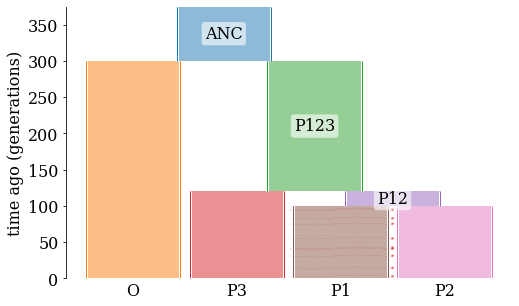

Demography(populations=[Population(initial_size=1000, growth_rate=0, name='P1', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=0), Population(initial_size=1000, growth_rate=0, name='P2', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=1), Population(initial_size=1000, growth_rate=0, name='P3', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=2), Population(initial_size=1000, growth_rate=0, name='O', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=3), Population(initial_size=1000, growth_rate=0, name='P12', description='', extra_metadata={}, default_sampling_time=100, initially_active=False, id=4), Population(initial_size=1000, growth_rate=0, name='P123', description='', extra_metadata={}, default_sampling_time=120, initially_active=False, id=5), Population(initial_size=1000, growth_rate=0, name='ANC', description='', extra_metadata={}, default_sampling_time=300, initially_active=False, id=6)], events=[PopulationSplit(time=100, derived=['P1', 'P2'], ancestral='P12'), PopulationSplit(time=120, derived=['P12', 'P3'], ancestral='P123'), PopulationSplit(time=300, derived=['P123', 'O'], ancestral='ANC')], migration_matrix=array([[0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.1, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. ]]))

In [163]:
#Example of the usage: no migration
set_demography(100,120,300,0.1,1000)

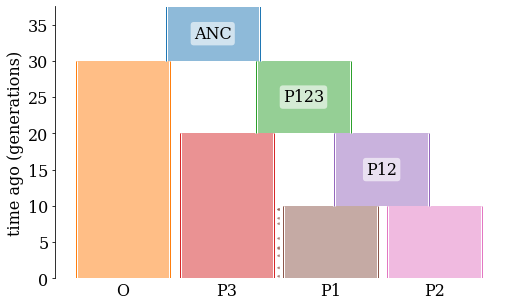

Demography(populations=[Population(initial_size=100, growth_rate=0, name='P1', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=0), Population(initial_size=100, growth_rate=0, name='P2', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=1), Population(initial_size=100, growth_rate=0, name='P3', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=2), Population(initial_size=100, growth_rate=0, name='O', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=3), Population(initial_size=100, growth_rate=0, name='P12', description='', extra_metadata={}, default_sampling_time=10, initially_active=False, id=4), Population(initial_size=100, growth_rate=0, name='P123', description='', extra_metadata={}, default_sampling_time=20, initially_active=False, id=5), Population(initial_size=100, growth_rate=0, name='ANC', description='', extra_metadata={}, default_sampling_time=30, initially_active=False, id=6)], events=[PopulationSplit(time=10, derived=['P1', 'P2'], ancestral='P12'), PopulationSplit(time=20, derived=['P12', 'P3'], ancestral='P123'), PopulationSplit(time=30, derived=['P123', 'O'], ancestral='ANC')], migration_matrix=array([[0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.1, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. ]]))

In [26]:
#Example of the usage: migration at rate 0.1
set_demography(10,20,30,0.1,100)

### Setting up simulations

`simulate_windows(num_replicates,demography)`

Simulates one window with length 10000 (10kb).  
Simulation consists of two steps. First creates ancestry of the sample. One haploid individual is sampled from each of the populations (((P1,P2),P3),O). The second step adds mutations with the rate **1/10000** (note: clarify)

> Note: We assume no recombination within the window, recombination is not included in the simulation

Parameters to specify are:
- `num_replicates`
- `demography` can be specified using the function above

In [133]:
def simulate_windows(num_replicates,demography):
    ancestry_reps = msprime.sim_ancestry(samples={"P1": 1, "P2": 1, "P3": 1, "O": 1}, 
                                         demography=demography, sequence_length=10000,
                                         num_replicates=num_replicates, ploidy=1)
    for ts in ancestry_reps:
        mutated_ts = msprime.sim_mutations(ts, rate=(1/100000))
        yield mutated_ts

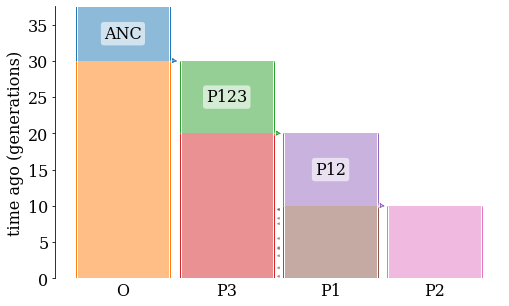

Number of mutations on the tree 2266


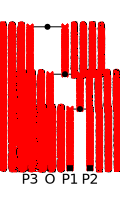

Number of mutations on the tree 4903


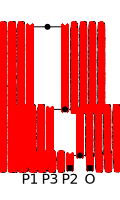

Number of mutations on the tree 5519


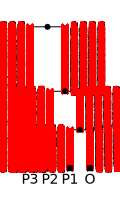

In [14]:
num_replicates = 3
windows=simulate_windows(num_replicates,set_demography(10,20,30,0.1,1000))
for replicate_index, ts in enumerate(windows):
    for t in ts.trees():
        print("Number of mutations on the tree "+str(t.num_mutations))
        display(SVG(t.draw_svg(node_labels={0: "P1", 1: "P2", 2: "P3", 3 : "O"}, order="tree", size=(120, 200))))

### Summarizing tree sequences, ternary plot

Simulations above will output replicates of tree sequences (all in one iterable object). In this section we develop the way to efficiently output the result of simulation and calculate values for ternary plots.

Simple simulation outputs the tree sequence object:

In [8]:
ts = msprime.sim_ancestry(4)
ts

For the ternary plot we only need information about tree topologies, which are compactly stored in "rank" parameter. See tskit manual for the details: https://tskit.dev/tskit/docs/latest/topological-analysis.html

Below we visualize ranks corresponding to **Topology r** (node names now correspond to Figure 2 of the manuscript):

Topology r
Visualizing rank (3, 2)


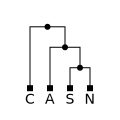

Visualizing rank (3, 4)


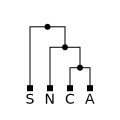

Visualizing rank (3, 9)


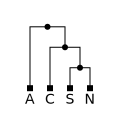

Visualizing rank (3, 7)


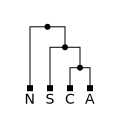

Visualizing rank (4, 2)


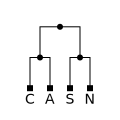

In [122]:
print("Topology r")
for rank in [(3,2), (3, 4), (3, 9),(3,7), (4, 2)]:
    t = tskit.Tree.unrank(num_leaves=4, rank=rank)
    print("Visualizing rank", rank)
    display(SVG(t.draw_svg(node_labels={0: "C", 1: "S", 2: "N", 3 : "A"}, order="tree", size=(120, 120))))

**Topology c**:

Topology c
Visualizing rank (4, 1)


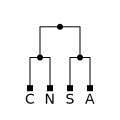

Visualizing rank (3, 10)


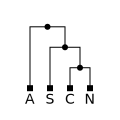

Visualizing rank (3, 6)


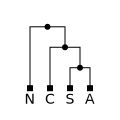

Visualizing rank (3, 5)


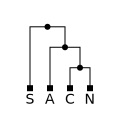

Visualizing rank (3, 1)


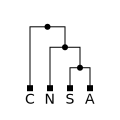

In [121]:
print("Topology c")
for rank in [(4,1), (3, 10), (3, 6),(3,5), (3, 1)]:
    t = tskit.Tree.unrank(num_leaves=4, rank=rank)
    print("Visualizing rank", rank)
    display(SVG(t.draw_svg(node_labels={0: "C", 1: "S", 2: "N", 3 : "A"}, order="tree", size=(120, 120))))

**Topology s**:

Topology s
Visualizing rank (4, 0)


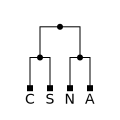

Visualizing rank (3, 11)


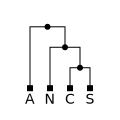

Visualizing rank (3, 8)


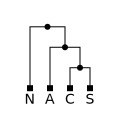

Visualizing rank (3, 0)


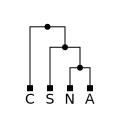

Visualizing rank (3, 3)


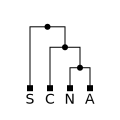

In [120]:
print("Topology s")
for rank in [(4,0), (3, 11), (3, 8),(3,0), (3, 3)]:
    t = tskit.Tree.unrank(num_leaves=4, rank=rank)
    print("Visualizing rank", rank)
    display(SVG(t.draw_svg(node_labels={0: "C", 1: "S", 2: "N", 3 : "A"}, order="tree", size=(120, 120))))

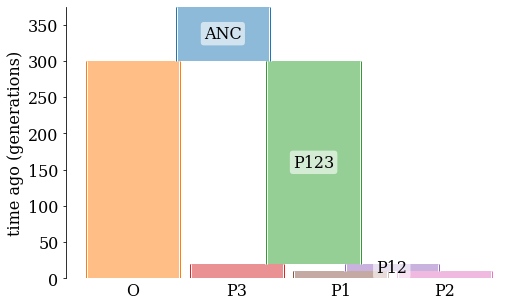

[(3, 10),
 (3, 11),
 (3, 10),
 (3, 11),
 (3, 9),
 (3, 9),
 (3, 10),
 (3, 10),
 (3, 10),
 (3, 11),
 (3, 11),
 (3, 11),
 (3, 11),
 (3, 11),
 (3, 10),
 (3, 10),
 (3, 11),
 (3, 11),
 (3, 9),
 (3, 9),
 (3, 9),
 (3, 9),
 (3, 11),
 (3, 9),
 (3, 10),
 (3, 8),
 (3, 9),
 (3, 10),
 (3, 11),
 (3, 10),
 (4, 1),
 (3, 11),
 (3, 11),
 (3, 11),
 (3, 11),
 (3, 9),
 (3, 11),
 (3, 9),
 (3, 11),
 (3, 9),
 (3, 10),
 (3, 9),
 (3, 11),
 (3, 11),
 (3, 10),
 (3, 11),
 (3, 11),
 (3, 9),
 (3, 11),
 (3, 11),
 (3, 9),
 (3, 11),
 (3, 11),
 (3, 11),
 (3, 11),
 (3, 10),
 (3, 10),
 (3, 9),
 (3, 9),
 (4, 2),
 (3, 11),
 (3, 11),
 (3, 11),
 (4, 1),
 (3, 10),
 (3, 11),
 (3, 10),
 (3, 11),
 (3, 10),
 (3, 10),
 (3, 9),
 (3, 10),
 (3, 10),
 (3, 9),
 (3, 10),
 (3, 10),
 (3, 11),
 (3, 9),
 (3, 10),
 (3, 9),
 (3, 11),
 (3, 10),
 (3, 11),
 (3, 10),
 (3, 10),
 (3, 11),
 (3, 10),
 (3, 11),
 (3, 9),
 (3, 9),
 (3, 10),
 (3, 10),
 (3, 9),
 (3, 9),
 (3, 11),
 (3, 11),
 (3, 10),
 (3, 11),
 (3, 9),
 (4, 1)]

In [164]:
windows=simulate_windows(100,set_demography(10,20,300,0,100))
produce_ranks(windows)

Next we gather rank information from all the iterations: 

`produce_ranks` outputs ranks from all simulated windows

`summarize_ranks(num_replicates,ranks)`   
Counts three types of topologies and produces a vector  
`[%topology r,%topology s,%topology c]` 

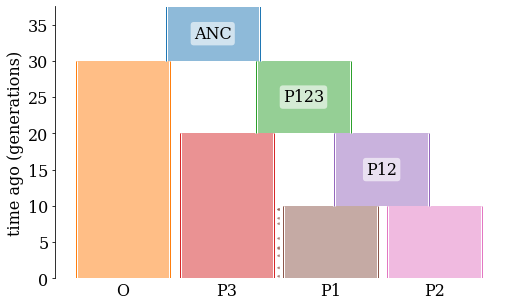

[25.0, 36.0, 39.0]

In [123]:
ranks=produce_ranks(simulate_windows(100,set_demography(10,20,30,0.1,100)))
summarize_ranks(100,ranks)    

`tern_plot(data)`

Plots a ternary graph given the data in format `three_points=[[33,33,33],[0,100,0],[70,10,20]]`

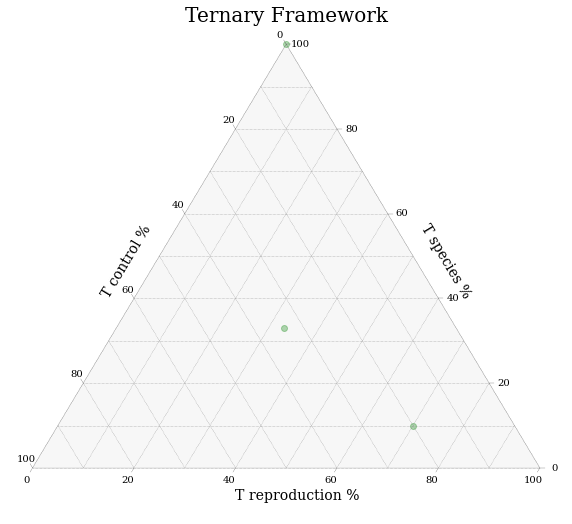

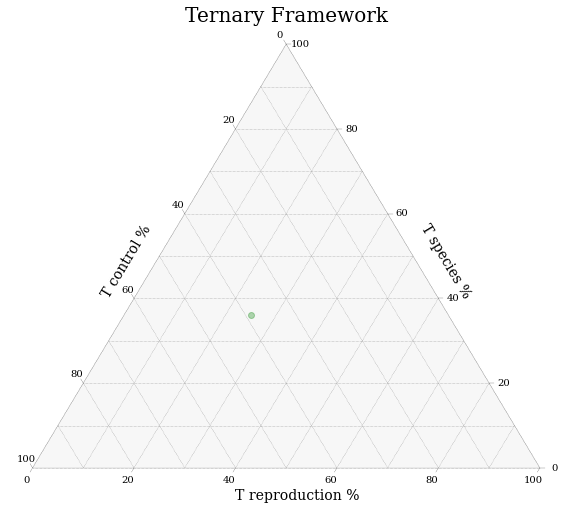

In [126]:
tern_plot([[33,33,33],[0,100,0],[70,10,20]])
tern_plot([summarize_ranks(100,ranks)])

### Output asymmetry statistics

### Creating data set

We can now combine functions above and generate multiple data points:

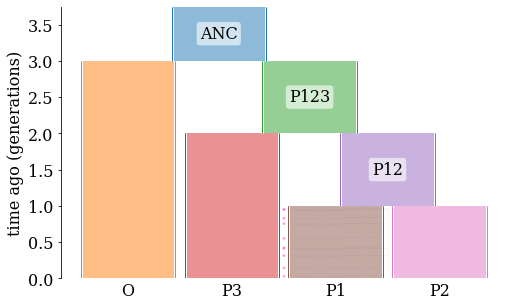

[43.0, 24.0, 33.0]


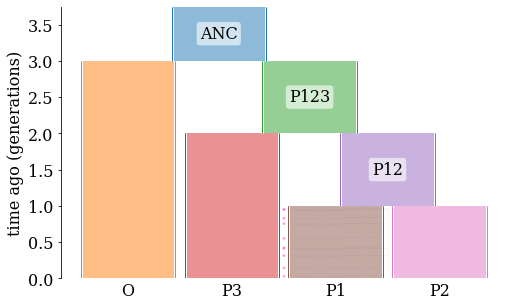

[36.0, 33.0, 31.0]


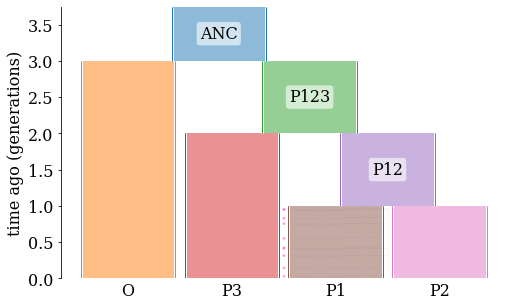

[32.0, 33.0, 35.0]


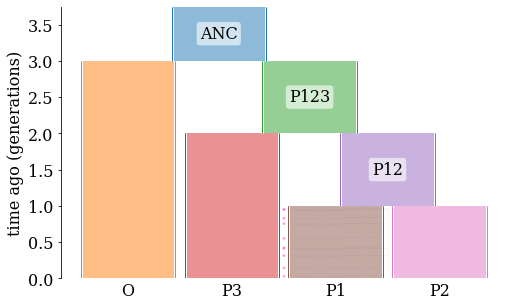

[31.0, 32.0, 37.0]


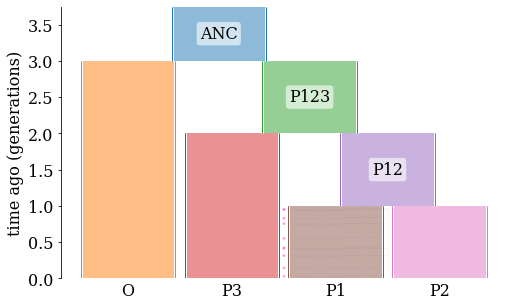

[37.0, 30.0, 33.0]
[[43.0, 24.0, 33.0], [36.0, 33.0, 31.0], [32.0, 33.0, 35.0], [31.0, 32.0, 37.0], [37.0, 30.0, 33.0]]


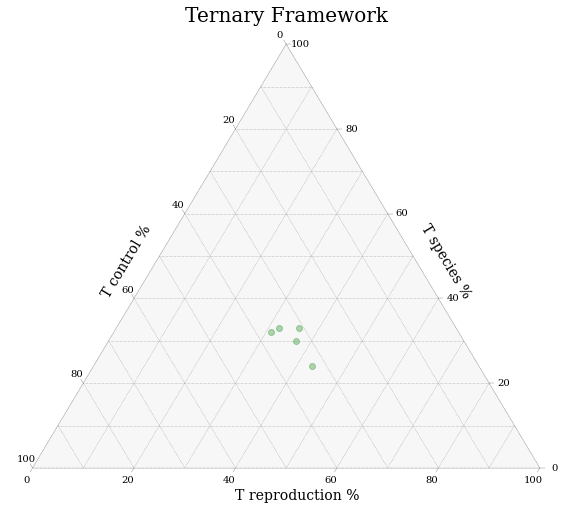

In [10]:
topo_sum=[]
for i in range(5):
    ranks=produce_ranks(simulate_windows(100,set_demography(1,2,3,0.05,1000)))
    print(summarize_ranks(100,ranks))
    topo_sum.append(summarize_ranks(100,ranks))
    
print(topo_sum)
tern_plot(topo_sum)

We can now generalize this into one function and silence visualization of the model

`make_data(num_data_points,num_replicates,t1,t2,t3,Ne,mig_rate)`  
    All the arguments like before

[[32.0, 35.0, 33.0]]


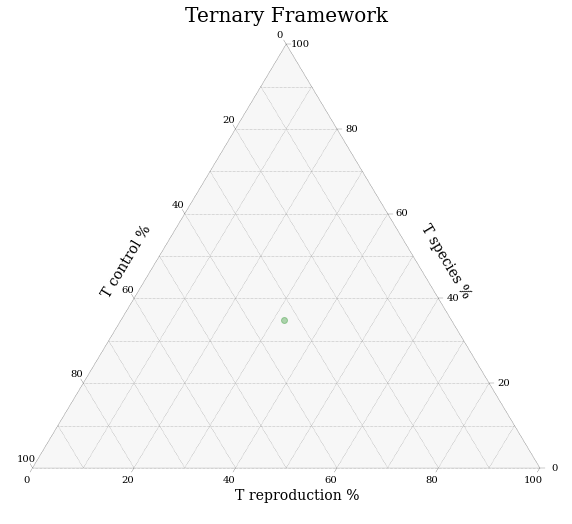

In [32]:
num_data_points=1
num_replicates=100
t1=10
t2=20
t3=30
Ne=1000
mig_rate=0.6

data=make_data(num_data_points,num_replicates,t1,t2,t3,Ne,mig_rate)
print(data)

#Option to save raw outputs
#f = open("/Users/dshipilina/GitHub/LittorinaBrooding/results.tsv", "x")
#f.write(str(data))
#f.close()

tern_plot(data)

## Analysis

We start from model without the gene flow and visualize influence of the split time: 

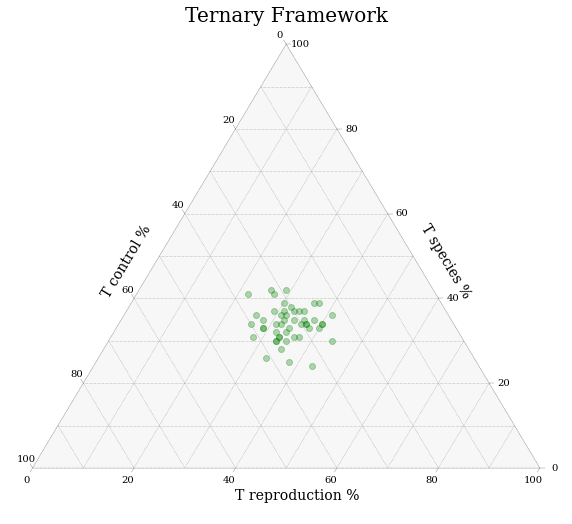

In [33]:
num_data_points=50
num_replicates=100
t1=10
t2=20
t3=30
Ne=1000
mig_rate=0

data=make_data(num_data_points,num_replicates,t1,t2,t3,Ne,mig_rate)
#print(data)

#Option to save raw outputs
#f = open("/Users/dshipilina/GitHub/LittorinaBrooding/results.tsv", "x")
#f.write(str(data))
#f.close()

tern_plot(data)
#Option to save plot
#plt.savefig("/Users/dshipilina/GitHub/LittorinaBrooding/null10_20_120_"+run_name+".pdf",bbox_inches="tight")

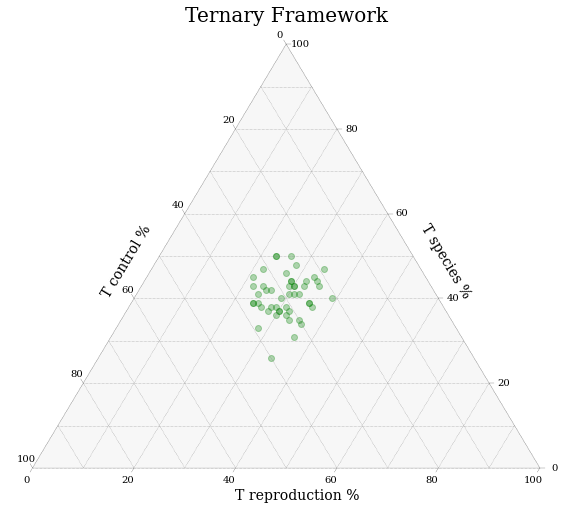

In [36]:
#Increasing the split times proportionally

num_data_points=50
num_replicates=100
t1=100
t2=200
t3=300
Ne=1000
mig_rate=0

data=make_data(num_data_points,num_replicates,t1,t2,t3,Ne,mig_rate)
tern_plot(data)

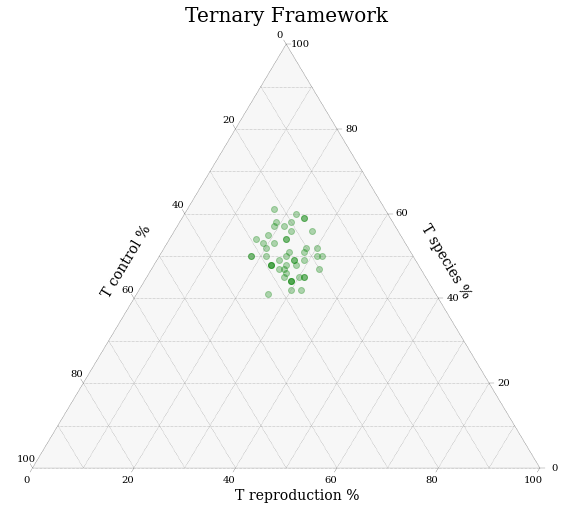

In [38]:
#Increasing the split times proportionally

num_data_points=50
num_replicates=100
t1=100
t2=400
t3=500
Ne=1000
mig_rate=0

data=make_data(num_data_points,num_replicates,t1,t2,t3,Ne,mig_rate)
tern_plot(data)

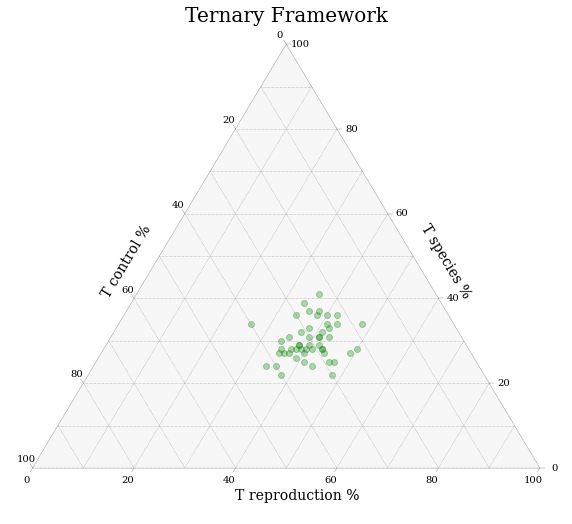

In [39]:
#Adding gene flow

num_data_points=50
num_replicates=100
t1=100
t2=200
t3=500
Ne=1000
mig_rate=0.6

data=make_data(num_data_points,num_replicates,t1,t2,t3,Ne,mig_rate)
tern_plot(data)

# OLD: Summarizing topologies

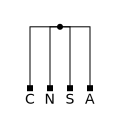

(0, 0)


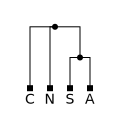

(1, 0)


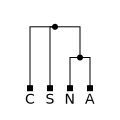

(1, 1)


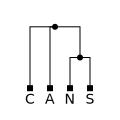

(1, 2)


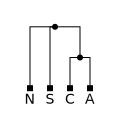

(1, 3)


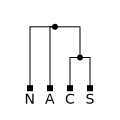

(1, 4)


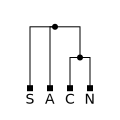

(1, 5)


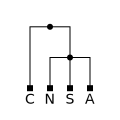

(2, 0)


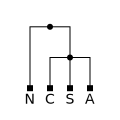

(2, 1)


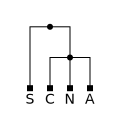

(2, 2)


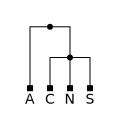

(2, 3)


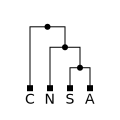

(3, 0)


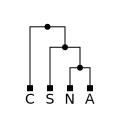

(3, 1)


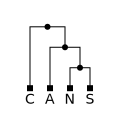

(3, 2)


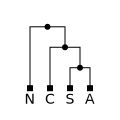

(3, 3)


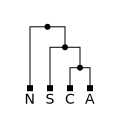

(3, 4)


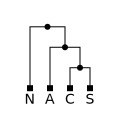

(3, 5)


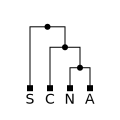

(3, 6)


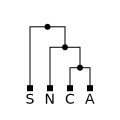

(3, 7)


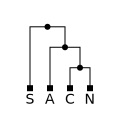

(3, 8)


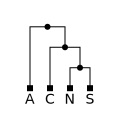

(3, 9)


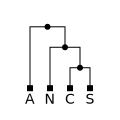

(3, 10)


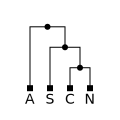

(3, 11)


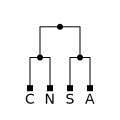

(4, 0)


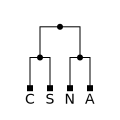

(4, 1)


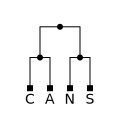

(4, 2)


In [3]:
#Visualizing topologies
for t in tskit.all_trees(num_leaves=4):
    display(SVG(t.draw_svg(node_labels={0: "C", 1: "N", 2: "S",3:"A"}, order="tree", size=(120, 120))))
    print(t.rank())

#### Function: produce ranks

In [18]:
def produce_ranks(ts_reps):
    ranks=[]
    for replicate_index, ts in enumerate(ts_reps):
        for t in ts.trees():
            ranks+=[t.rank()]
        
    return ranks
    
produce_ranks(sim_null_model(50))

[(3, 11),
 (3, 10),
 (4, 1),
 (4, 1),
 (3, 3),
 (4, 0),
 (3, 9),
 (3, 3),
 (4, 0),
 (4, 0),
 (3, 11),
 (3, 2),
 (3, 3),
 (3, 10),
 (3, 1),
 (4, 1),
 (4, 2),
 (4, 0),
 (4, 0),
 (4, 0),
 (3, 0),
 (3, 8),
 (3, 9),
 (4, 1),
 (3, 4),
 (3, 11),
 (3, 5),
 (3, 5),
 (3, 6),
 (3, 11),
 (4, 1),
 (3, 10),
 (3, 8),
 (3, 10),
 (4, 2),
 (4, 0),
 (4, 2),
 (3, 5),
 (3, 9),
 (3, 11),
 (3, 9),
 (3, 11),
 (3, 7),
 (3, 2),
 (3, 8),
 (3, 11),
 (3, 9),
 (4, 1),
 (4, 0),
 (4, 0)]

In [51]:
ranks_sample=produce_ranks(sim_null_model(n_subtrees))

NameError: name 'sim_null_model' is not defined

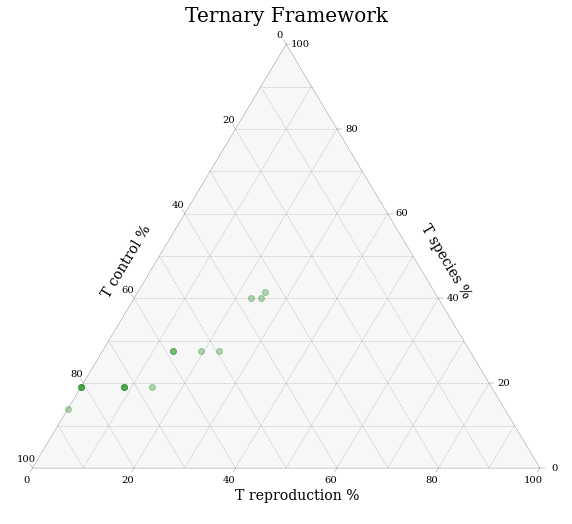

In [34]:
topo_weight=[]
topS_count = []
topC_count = []
topR_count = []

rank_dict=collections.Counter(ranks_sample)
    
for key, value in rank_dict.items():
        #print(key, value)
    if key == (4,0) or key == (3,11) or key == (3,8) or key == (3,0) or key == (3,3):
            #print("yay")#TOPOLOGY S
            #print(key)
        topS_count.append(value)
        #TOPOLOGY S
    elif key == (4,1) or key == (3, 10) or key ==(3, 6) or key == (3,5) or key == (3, 1):
        topC_count.append(value)
        # TOPOLOGY C
    else:
        #key == (3,2) or key == (3, 4) or key == (3, 9) or key == (3,7) or key == (4, 2):
        topR_count.append(value)
        # TOPOLOGY R

    #one_value=[(sum(topS_count)),sum(topC_count),sum(topR_count)]
    #print(sum(topS_count), sum(topC_count),sum(topR_count))
    #one_value=[(sum(topS_count)/n_subtrees),sum(topC_count)/n_subtrees,sum(topR_count)/n_subtrees]
    #print((sum(topS_count)/n_subtrees)*100, sum(topC_count)/n_subtrees*100, sum(topR_count)/n_subtrees*100)
    one_value=[(sum(topR_count)/n_subtrees)*100, sum(topS_count)/n_subtrees*100, sum(topC_count)/n_subtrees*100]
    #print(one_value)
    topo_weight.append(one_value)
    
tern_plot(topo_weight)

### Null model analysis

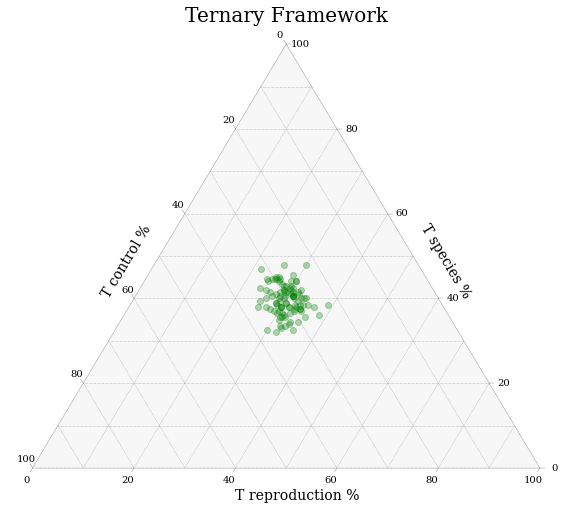

In [31]:
run_name="t5_t10_t20"
n_subtrees=200
topo_weight=[]
for _ in range(100):
    topS_count = []
    topC_count = []
    topR_count = []
    rank_dict=collections.Counter(produce_ranks(sim_null_model_flex(n_subtrees,10,20,1000
                                                                   )))
    for key, value in rank_dict.items():
        #print(key, value)
        if key == (4,0) or key == (3,11) or \
            key == (3,8) or key == (3,0) or key == (3,3):
            #print("yay")#TOPOLOGY S
            #print(key)
            topS_count.append(value)
        #TOPOLOGY S
        elif key == (4,1) or key == (3, 10) or key ==(3, 6) or key == (3,5) or key == (3, 1):
            topC_count.append(value)
        # TOPOLOGY C
        else:
        #key == (3,2) or key == (3, 4) or key == (3, 9) or key == (3,7) or key == (4, 2):
            topR_count.append(value)
        # TOPOLOGY R

    #one_value=[(sum(topS_count)),sum(topC_count),sum(topR_count)]
    #print(sum(topS_count), sum(topC_count),sum(topR_count))
    #one_value=[(sum(topS_count)/n_subtrees),sum(topC_count)/n_subtrees,sum(topR_count)/n_subtrees]
    #print((sum(topS_count)/n_subtrees)*100, sum(topC_count)/n_subtrees*100, sum(topR_count)/n_subtrees*100)
    one_value=[(sum(topR_count)/n_subtrees)*100, sum(topS_count)/n_subtrees*100, sum(topC_count)/n_subtrees*100]
    #print(one_value)
    topo_weight.append(one_value)
tern_plot(topo_weight)
#plt.savefig("/Users/dshipilina/GitHub/LittorinaBrooding/null_"+run_name+".pdf",bbox_inches="tight")

### Visualizing split time differences

t10_t100_t120


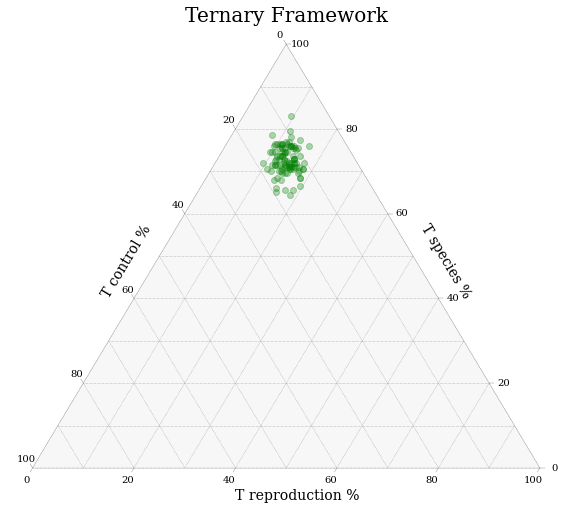

In [40]:
t12=10
t23=100
t34=120

run_name="t"+str(t12)+"_t"+str(t23)+"_t"+str(t34)
print(run_name)
n_subtrees=200
topo_weight=[]
for _ in range(100):
    topS_count = []
    topC_count = []
    topR_count = []
    rank_dict=collections.Counter(produce_ranks(sim_null_model_flex(n_subtrees,t12,t23,t34)))
    for key, value in rank_dict.items():
        #print(key, value)
        if key == (4,0) or key == (3,11) or \
            key == (3,8) or key == (3,0) or key == (3,3):
            #print("yay")#TOPOLOGY S
            #print(key)
            topS_count.append(value)
        #TOPOLOGY S
        elif key == (4,1) or key == (3, 10) or key ==(3, 6) or key == (3,5) or key == (3, 1):
            topC_count.append(value)
        # TOPOLOGY C
        else:
        #key == (3,2) or key == (3, 4) or key == (3, 9) or key == (3,7) or key == (4, 2):
            topR_count.append(value)
        # TOPOLOGY R
        
    one_value=[(sum(topR_count)/n_subtrees)*100, sum(topS_count)/n_subtrees*100, sum(topC_count)/n_subtrees*100]
    topo_weight.append(one_value)
    
    
tern_plot(topo_weight)
plt.savefig("/Users/dshipilina/GitHub/LittorinaBrooding/null_"+run_name+".pdf",bbox_inches="tight")

### Visualizing Ne differences

Ne10_Ne100_Ne100_Ne1000


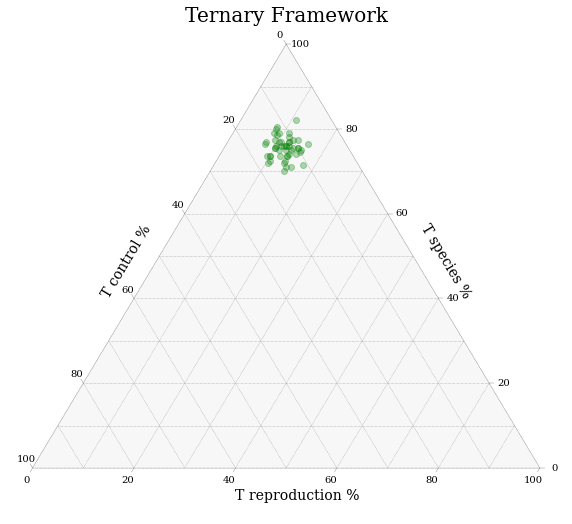

In [48]:
NeA=10
NeB=100
NeC=100
NeD=1000

run_name="Ne"+str(NeA)+"_Ne"+str(NeB)+"_Ne"+str(NeC)+"_Ne"+str(NeD)
print(run_name)
n_subtrees=200
topo_weight=[]
for _ in range(50):
    topS_count = []
    topC_count = []
    topR_count = []
    rank_dict=collections.Counter(produce_ranks(sim_null_model_Ne(n_subtrees,NeA,NeB,NeC,NeD)))
    for key, value in rank_dict.items():
        #print(key, value)
        if key == (4,0) or key == (3,11) or \
            key == (3,8) or key == (3,0) or key == (3,3):
            #print("yay")#TOPOLOGY S
            #print(key)
            topS_count.append(value)
        #TOPOLOGY S
        elif key == (4,1) or key == (3, 10) or key ==(3, 6) or key == (3,5) or key == (3, 1):
            topC_count.append(value)
        # TOPOLOGY C
        else:
        #key == (3,2) or key == (3, 4) or key == (3, 9) or key == (3,7) or key == (4, 2):
            topR_count.append(value)
        # TOPOLOGY R
        
    one_value=[(sum(topR_count)/n_subtrees)*100, sum(topS_count)/n_subtrees*100, sum(topC_count)/n_subtrees*100]
    topo_weight.append(one_value)
    
    
tern_plot(topo_weight)
plt.savefig("/Users/dshipilina/GitHub/LittorinaBrooding/null10_20_120_"+run_name+".pdf",bbox_inches="tight")

5 1 4
8 2 0
6 2 2
3 3 4
4 3 3
7 0 3
5 3 2
4 3 3
3 1 6
4 2 4


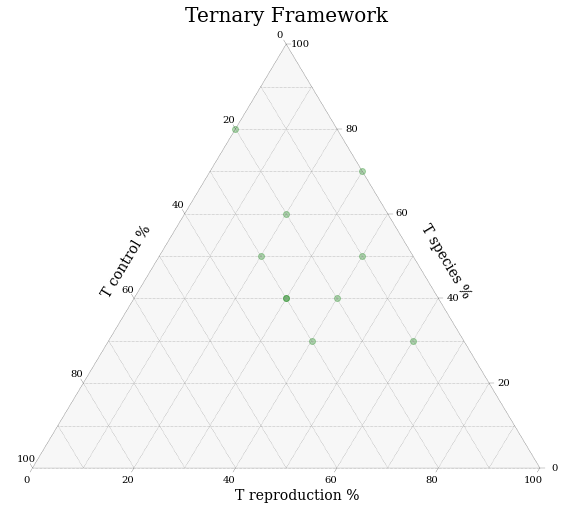

In [50]:
n_subtrees=10
topo_weight=[]

for _ in range(10):
    topS_count = []
    topC_count = []
    topR_count = []
    rank_dict=collections.Counter(produce_ranks(sim_null_model(n_subtrees)))
    for key, value in rank_dict.items():
        #print(key, value)
        if key == (4,0) or key == (3,11) or \
            key == (3,8) or key == (3,0) or key == (3,3):
            topS_count.append(value)
        #TOPOLOGY S
        elif key == (4,1) or key == (3, 10) or key ==(3, 6) or key == (3,5) or key == (3, 1):
            topC_count.append(value)
        # TOPOLOGY C
        else: #key == (3,2) or key == (3, 4) or key == (3, 9) or key == (3,7) or key == (4, 2):
            topR_count.append(value)
        # TOPOLOGY R

    #one_value=[(sum(topS_count)),sum(topC_count),sum(topR_count)]
    print(sum(topS_count), sum(topC_count),sum(topR_count))
    #one_value=[(sum(topS_count)/n_subtrees),sum(topC_count)/n_subtrees,sum(topR_count)/n_subtrees]
    #print((sum(topS_count)/n_subtrees)*100, sum(topC_count)/n_subtrees*100, sum(topR_count)/n_subtrees*100)
    one_value=[(sum(topR_count)/n_subtrees)*100, sum(topS_count)/n_subtrees*100, sum(topC_count)/n_subtrees*100]
    #print(one_value)
    topo_weight.append(one_value)
tern_plot(topo_weight)

33 34 33
35 35 30
42 28 30
51 18 31
38 27 35
47 28 25
37 26 37
41 25 34
29 34 37
34 34 32
46 23 31
37 32 31
38 25 37
39 29 32
47 23 30
38 32 30
42 35 23
38 27 35
48 28 24
38 36 26
39 36 25
45 29 26
37 27 36
38 36 26
37 32 31
39 25 36
38 33 29
40 19 41
38 29 33
33 36 31
39 25 36
33 40 27
34 28 38
40 29 31
43 25 32
38 26 36
35 31 34
34 34 32
45 27 28
47 26 27
39 31 30
36 39 25
41 28 31
35 25 40
44 29 27
44 36 20
43 28 29
36 30 34
39 31 30
40 24 36
46 28 26
45 35 20
36 31 33
34 38 28
43 32 25
42 33 25
41 30 29
39 34 27
42 33 25
40 21 39
42 30 28
39 32 29
50 27 23
40 34 26
39 27 34
43 21 36
40 30 30
46 27 27
30 33 37
48 29 23
38 28 34
39 25 36
39 35 26
37 33 30
40 39 21
36 32 32
39 27 34
35 30 35
38 28 34
43 26 31
43 26 31
36 33 31
31 28 41
43 26 31
50 27 23
51 26 23
41 32 27
45 29 26
39 30 31
30 37 33
38 36 26
38 35 27
36 36 28
53 23 24
37 27 36
34 35 31
39 34 27
45 25 30
37 37 26
36 42 22


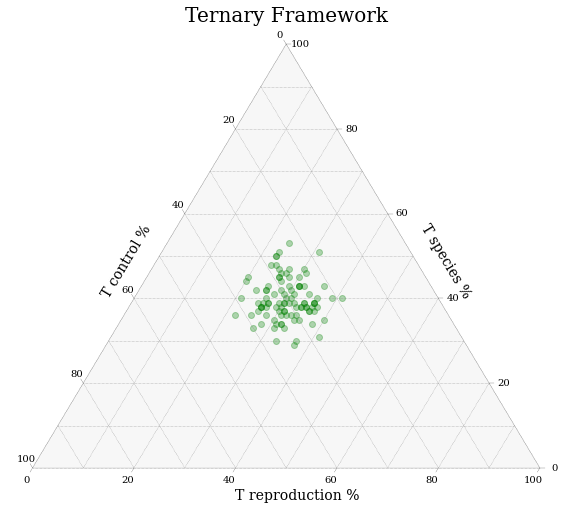

In [54]:
n_subtrees=100
topo_weight=[]

for _ in range(100):
    topS_count = []
    topC_count = []
    topR_count = []
    rank_dict=collections.Counter(produce_ranks(sim_null_model(n_subtrees)))
    for key, value in rank_dict.items():
        #print(key, value)
        if key == (4,0) or key == (3,11) or \
            key == (3,8) or key == (3,0) or key == (3,3):
            topS_count.append(value)
        #TOPOLOGY S
        elif key == (4,1) or key == (3, 10) or key ==(3, 6) or key == (3,5) or key == (3, 1):
            topC_count.append(value)
        # TOPOLOGY C
        elif key == (3,2) or key == (3, 4) or key == (3, 9) or key == (3,7) or key == (4, 2):
            topR_count.append(value)
        # TOPOLOGY R

    #one_value=[(sum(topS_count)),sum(topC_count),sum(topR_count)]
    print(sum(topS_count), sum(topC_count),sum(topR_count))
    #one_value=[(sum(topS_count)/n_subtrees),sum(topC_count)/n_subtrees,sum(topR_count)/n_subtrees]
    #print((sum(topS_count)/n_subtrees)*100, sum(topC_count)/n_subtrees*100, sum(topR_count)/n_subtrees*100)
    one_value=[(sum(topR_count)/n_subtrees)*100, sum(topS_count)/n_subtrees*100, sum(topC_count)/n_subtrees*100]
    #print(one_value)
    topo_weight.append(one_value)
tern_plot(topo_weight)

#### Testing null model functions

In [17]:
n_subtrees=100
topo_weight=[]
for _ in range(100):
    topS_count = []
    topC_count = []
    topR_count = []
    rank_dict=collections.Counter(produce_ranks(sim_null_model(n_subtrees)))
    for key, value in rank_dict.items():
        #print(key, value)
        if key == (4,0) or key == (3,11) or \
            key == (3,8) or key == (3,0) or key == (3,3):
            #print("yay")#TOPOLOGY S
            #print(key)
            topS_count.append(value)
        #TOPOLOGY S
        elif key == (4,1) or key == (3, 10) or key ==(3, 6) or key == (3,5) or key == (3, 1):
            topC_count.append(value)
        # TOPOLOGY C
        else:
        #key == (3,2) or key == (3, 4) or key == (3, 9) or key == (3,7) or key == (4, 2):
            topR_count.append(value)
        # TOPOLOGY R

    #one_value=[(sum(topS_count)),sum(topC_count),sum(topR_count)]
    #print(sum(topS_count), sum(topC_count),sum(topR_count))
    #one_value=[(sum(topS_count)/n_subtrees),sum(topC_count)/n_subtrees,sum(topR_count)/n_subtrees]
    #print((sum(topS_count)/n_subtrees)*100, sum(topC_count)/n_subtrees*100, sum(topR_count)/n_subtrees*100)
    one_value=[(sum(topR_count)/n_subtrees)*100, sum(topS_count)/n_subtrees*100, sum(topC_count)/n_subtrees*100]
    #print(one_value)
    topo_weight.append(one_value)
tern_plot(topo_weight)

NameError: name 'produce_ranks' is not defined

In [12]:
# L/O

In [33]:
collections.Counter(produce_ranks(sim_null_model(10)))

Counter({(3, 5): 1,
         (3, 11): 4,
         (3, 2): 1,
         (4, 2): 1,
         (3, 10): 1,
         (3, 8): 1,
         (3, 9): 1})

In [132]:
num_replicates = 100000
#ranks = np.zeros(num_replicates)
ranks=[]
for replicate_index, ts in enumerate(sim_replicates(num_replicates)):
    for t in ts.trees():
        #print(t.rank())
        ranks+=[t.rank()]
        
print(ranks)

[(3, 4), (3, 9), (3, 3), (4, 2), (3, 8), (4, 0), (3, 2), (3, 10), (3, 6), (3, 5), (3, 10), (3, 10), (4, 1), (3, 8), (4, 0), (3, 10), (3, 2), (3, 9), (3, 4), (4, 1), (4, 0), (4, 1), (3, 9), (3, 4), (3, 10), (4, 1), (4, 2), (3, 0), (4, 1), (3, 10), (3, 9), (4, 2), (3, 8), (3, 10), (3, 8), (3, 11), (3, 5), (3, 2), (3, 1), (3, 0), (3, 7), (3, 0), (3, 1), (3, 2), (3, 8), (3, 0), (3, 0), (4, 0), (4, 0), (4, 2), (4, 2), (3, 0), (3, 7), (4, 1), (3, 6), (4, 0), (3, 11), (3, 3), (3, 7), (3, 1), (3, 6), (3, 2), (3, 0), (4, 0), (4, 0), (3, 3), (3, 4), (3, 1), (4, 2), (4, 0), (4, 1), (3, 3), (3, 7), (3, 7), (3, 10), (3, 1), (3, 7), (3, 8), (4, 2), (3, 5), (3, 9), (3, 8), (3, 6), (3, 7), (4, 1), (4, 1), (3, 9), (3, 5), (4, 0), (4, 1), (3, 4), (3, 0), (3, 7), (3, 3), (4, 2), (4, 1), (3, 10), (4, 2), (4, 1), (4, 2), (3, 8), (3, 9), (3, 7), (3, 0), (3, 9), (3, 1), (4, 0), (3, 3), (4, 1), (3, 5), (3, 1), (3, 6), (4, 2), (3, 5), (3, 7), (3, 2), (3, 11), (3, 7), (3, 8), (3, 7), (3, 9), (3, 8), (4, 2), (3,

In [147]:
#Summarize Topology s
#for rank in [(4,0), (3, 11), (3, 8),(3,0), (3, 3)]:
collections.Counter(ranks)[(3, 4)][(3, 8)]

TypeError: 'int' object is not subscriptable

In [171]:
ranks[1:10]

[(3, 9), (3, 3), (4, 2), (3, 8), (4, 0), (3, 2), (3, 10), (3, 6), (3, 5)]

In [ ]:
from itertools import chain, islice

def ichunked(seq, chunksize):
    """Yields items from an iterator in iterable chunks."""
    it = iter(seq)
    while True:
        yield chain([it.next()], islice(it, chunksize-1))

def chunked(seq, chunksize):
    """Yields items from an iterator in list chunks."""
    for chunk in ichunked(seq, chunksize):
        yield list(chunk)

In [187]:
#rank_dict=collections.Counter(ranks[0:10000])
n_subtrees=100
rank_dict=collections.Counter(random.sample(ranks, n_subtrees))
#name = "ABC"
topS_count = []
topC_count = []
topR_count = []
#(4,0),(3, 11),(3, 8),(3,0),(3, 3)]
#for character in name:
for key, value in rank_dict.items():
    print(key, value)
    if key == (4,0) or key == (3,11) or \
        key == (3,8) or key == (3,0) or key == (3,3):    #TOPOLOGY S
        topS_count.append(value)
        #TOPOLOGY S
    elif key == (4,1) or key == (3, 10) or key ==(3, 6) or key == (3,5) or key == (3, 1):
        topC_count.append(value)
        # TOPOLOGY C
    else:
        #key == (3,2) or key == (3, 4) or key == (3, 9) or key == (3,7) or key == (4, 2):
        topR_count.append(value)
        # TOPOLOGY R
#sum(values)

print(topS_count, topC_count, topR_count)
print(sum(topS_count), sum(topC_count), sum(topR_count))
print(sum(topS_count) + sum(topC_count) + sum(topR_count))

one_value=[(sum(topS_count)/n_subtrees),sum(topC_count)/n_subtrees,sum(topR_count)/n_subtrees]
print([(sum(topS_count)/n_subtrees),sum(topC_count)/n_subtrees,sum(topR_count)/n_subtrees])

(4, 2) 9
(3, 0) 7
(3, 5) 4
(4, 0) 14
(4, 1) 12
(3, 8) 7
(3, 7) 8
(3, 2) 5
(3, 9) 4
(3, 3) 5
(3, 1) 8
(3, 6) 6
(3, 10) 5
(3, 4) 2
(3, 11) 4
[7, 14, 7, 5, 4] [4, 12, 8, 6, 5] [9, 8, 5, 4, 2]
37 35 28
100
[0.37, 0.35, 0.28]


In [15]:
#rank_dict=collections.Counter(ranks[0:10000])
n_subtrees=100
topo_weight=[]
for _ in range(1000):
    topS_count = []
    topC_count = []
    topR_count = []
    rank_dict=collections.Counter(random.sample(ranks, n_subtrees))
#(4,0),(3, 11),(3, 8),(3,0),(3, 3)]
#for character in name:
    for key, value in rank_dict.items():
        #print(key, value)
        if key == (4,0) or key == (3,11) or \
            key == (3,8) or key == (3,0) or key == (3,3):    #TOPOLOGY S
            topS_count.append(value)
        #TOPOLOGY S
        elif key == (4,1) or key == (3, 10) or key ==(3, 6) or key == (3,5) or key == (3, 1):
            topC_count.append(value)
        # TOPOLOGY C
        else:
        #key == (3,2) or key == (3, 4) or key == (3, 9) or key == (3,7) or key == (4, 2):
            topR_count.append(value)
        # TOPOLOGY R

    one_value=[(sum(topS_count)),sum(topC_count),sum(topR_count)]
    print(one_value)
    topo_weight.append(one_value)
    tern_plot(topo_weight)

NameError: name 'ranks' is not defined

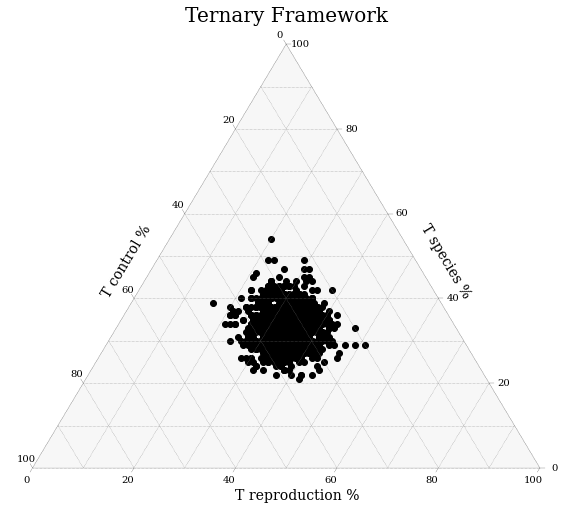

In [205]:
tern_plot(topo_weight)

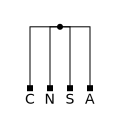

(0, 0)


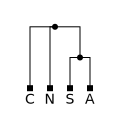

(1, 0)


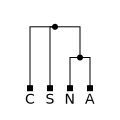

(1, 1)


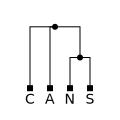

(1, 2)


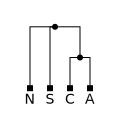

(1, 3)


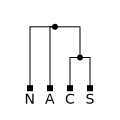

(1, 4)


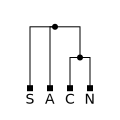

(1, 5)


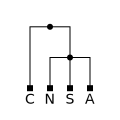

(2, 0)


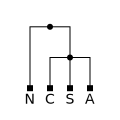

(2, 1)


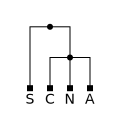

(2, 2)


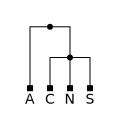

(2, 3)


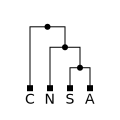

(3, 0)


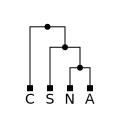

(3, 1)


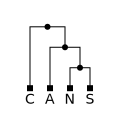

(3, 2)


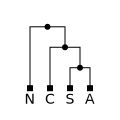

(3, 3)


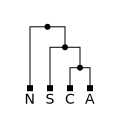

(3, 4)


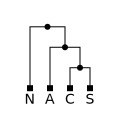

(3, 5)


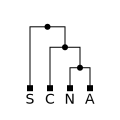

(3, 6)


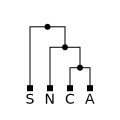

(3, 7)


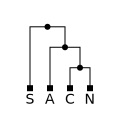

(3, 8)


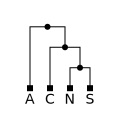

(3, 9)


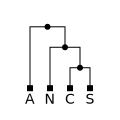

(3, 10)


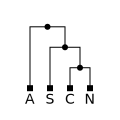

(3, 11)


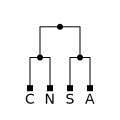

(4, 0)


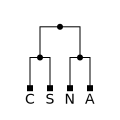

(4, 1)


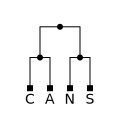

(4, 2)


In [8]:
for t in tskit.all_trees(num_leaves=4):
    display(SVG(t.draw_svg(node_labels={0: "C", 1: "N", 2: "S",3:"A"}, order="tree", size=(120, 120))))
    print(t.rank())

### Demographic model: neutral

In [80]:
def sim_test_null_model(num_replicates):
    demography = msprime.Demography()
    demography.add_population(name="A", initial_size=100)
    demography.add_population(name="B", initial_size=100)
    demography.add_population(name="C", initial_size=100)
    demography.add_population(name="D", initial_size=100)
    demography.add_population(name="AB", initial_size=100)
    demography.add_population(name="ABC", initial_size=100)
    demography.add_population(name="ABCD", initial_size=100)
    demography.add_population_split(time=10, derived=["A", "B"], ancestral="AB")
    demography.add_population_split(time=20, derived=["AB", "C"], ancestral="ABC")
    demography.add_population_split(time=30, derived=["ABC", "D"], ancestral="ABCD")
    #ancestry_reps = msprime.sim_ancestry(samples={"A": 1, "B": 1, "C": 1, "D": 1}, sequence_length=10000, demography=demography, num_replicates=num_replicates)
    ancestry_reps = msprime.sim_ancestry(samples={"A": 1, "B": 1, "C": 1, "D": 1}, 
                                         demography=demography, sequence_length=10000,
                                         num_replicates=num_replicates, ploidy=1)
    for ts in ancestry_reps:
        mutated_ts = msprime.sim_mutations(ts, rate=(1/10000))
        for t in mutated_ts.trees():
            print(t.rank())
            #display(SVG(t.draw_svg(node_labels={0: "A", 1: "B", 2: "C", 3 : "D"}, order="tree", size=(120, 120))))
    #yield ts
            
sim_test_null_model(50)

(3, 0)
(4, 0)
(3, 2)
(3, 0)
(3, 11)
(4, 0)
(3, 11)
(4, 1)
(4, 1)
(3, 11)
(3, 4)
(3, 3)
(3, 0)
(3, 8)
(3, 2)
(3, 9)
(4, 0)
(3, 1)
(3, 1)
(3, 9)
(4, 2)
(3, 4)
(4, 0)
(3, 5)
(3, 2)
(3, 7)
(3, 8)
(4, 0)
(3, 11)
(3, 9)
(3, 5)
(3, 8)
(3, 7)
(3, 11)
(3, 10)
(3, 7)
(3, 5)
(3, 11)
(4, 1)
(4, 1)
(3, 6)
(3, 7)
(3, 10)
(3, 10)
(3, 11)
(4, 1)
(4, 0)
(3, 3)
(3, 2)
(3, 3)


In [14]:
def sim_null_model(num_replicates):
    demography = msprime.Demography()
    demography.add_population(name="A", initial_size=100)
    demography.add_population(name="B", initial_size=100)
    demography.add_population(name="C", initial_size=100)
    demography.add_population(name="D", initial_size=100)
    demography.add_population(name="AB", initial_size=100)
    demography.add_population(name="ABC", initial_size=100)
    demography.add_population(name="ABCD", initial_size=100)
    demography.add_population_split(time=10, derived=["A", "B"], ancestral="AB")
    demography.add_population_split(time=20, derived=["AB", "C"], ancestral="ABC")
    demography.add_population_split(time=30, derived=["ABC", "D"], ancestral="ABCD")
    #ancestry_reps = msprime.sim_ancestry(samples={"A": 1, "B": 1, "C": 1, "D": 1}, sequence_length=10000, demography=demography, num_replicates=num_replicates)
    ancestry_reps = msprime.sim_ancestry(samples={"A": 1, "B": 1, "C": 1, "D": 1}, 
                                         demography=demography, sequence_length=10000,
                                         num_replicates=num_replicates, ploidy=1)
    for ts in ancestry_reps:
        mutated_ts = msprime.sim_mutations(ts, rate=(1/10000))
        yield ts
        
sim_null_model(50)

<generator object sim_null_model at 0x158a09430>

(3, 6)


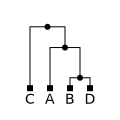

In [48]:
demography = msprime.Demography()
demography.add_population(name="A", initial_size=100)
demography.add_population(name="B", initial_size=100)
demography.add_population(name="C", initial_size=100)
demography.add_population(name="D", initial_size=100)
demography.add_population(name="AB", initial_size=100)
demography.add_population(name="ABC", initial_size=100)
demography.add_population(name="ABCD", initial_size=100)
demography.add_population_split(time=10, derived=["A", "B"], ancestral="AB")
demography.add_population_split(time=20, derived=["AB", "C"], ancestral="ABC")
demography.add_population_split(time=30, derived=["ABC", "D"], ancestral="ABCD")
    #ancestry_reps = msprime.sim_ancestry(samples={"A": 1, "B": 1, "C": 1, "D": 1}, sequence_length=10000, demography=demography, num_replicates=num_replicates)
ts = msprime.sim_ancestry(samples={"A": 1, "B": 1, "C": 1, "D": 1}, demography=demography, ploidy=1) #, random_seed=12)
ts
for t in ts.trees():
    print(t.rank())
    display(SVG(t.draw_svg(node_labels={0: "A", 1: "B", 2: "C", 3 : "D"}, order="tree", size=(120, 120))))
#print("Topology s")
#for rank in [(243,1767)]:
#    t = tskit.Tree.unrank(num_leaves=8, rank=rank)
#    print("Visualizing rank", rank)
#    display(SVG(t.draw_svg(node_labels={0: "C", 1: "S", 2: "N", 3 : "A"}, order="tree", size=(120, 120))))

In [15]:
sim_null_model(1)
for t in sim_null_model(1).trees():
    print(t.rank())

AttributeError: 'generator' object has no attribute 'trees'

In [10]:
#demography = msprime.Demography.isolated_model([100] * 4)

In [12]:
print(demography)

Demography
╟  Populations
║  ┌────────────────────────────────────────────────────────────────────────────────────────────────┐
║  │ id │name   │description  │initial_size  │ growth_rate │  default_sampling_time│extra_metadata  │
║  ├────────────────────────────────────────────────────────────────────────────────────────────────┤
║  │ 0  │pop_0  │             │100.0         │      0      │                      0│{}              │
║  │ 1  │pop_1  │             │100.0         │      0      │                      0│{}              │
║  │ 2  │pop_2  │             │100.0         │      0      │                      0│{}              │
║  │ 3  │pop_3  │             │100.0         │      0      │                      0│{}              │
║  └────────────────────────────────────────────────────────────────────────────────────────────────┘
╟  Migration Matrix
║  ┌───────────────────────────────────────┐
║  │       │ pop_0 │ pop_1 │ pop_2 │ pop_3 │
║  ├───────────────────────────────────────┤
║  

### Demographic models from Martin et al.

In [ ]:
def make_data(num_data_points,num_replicates,t1,t2,t3,Ne,mig_rate):
    topo_sum=[]
    for i in range(num_data_points):
        ranks=produce_ranks(simulate_windows(num_replicates,set_demography_s(t1,t2,t3,mig_rate,Ne)))
        #print(summarize_ranks(100,ranks))
        topo_sum.append(summarize_ranks(num_replicates,ranks))
    #print(topo_sum)
    return topo_sum
    



To assess how reliably Patterson’s D statistic, and other estimators of f are able to quantify 
the actual rate of introgression, we simulated sequence data sets with differing rates of introgression
using ms (Hudson 2002). For each data set, we simulated 100 sequence windows for eight haplotypes each 
from four populations with the relationship (((P1,P2),P3),O). The split times t12 and t23 (as on fig. 1A) 
were set to 1 × 4N generations and 2 × 4N generations ago, respectively, and the root was set to 3 × 4N generations ago. An instantaneous, unidirectional admixture event, either from P3 to P2 or from P2 to P3, was simulated at a time tGF with a value f, which determines the probability that each haplotype is shared. We tested two different values for tGF: 0.1 and 0.5 × 4N generations ago. For each direction of gene flow and each tGF, 11 simulated data sets were produced, with f values ranging from 0 (no gene flow) to 1 (all haplotypes are shared). Finally, the entire set of simulations was repeated with three different window sizes: 1, 5, and 10 kb, and with three different recombination rates: 0.001, 0.01, and 0.1, in units of 4Nr, the population recombination rate. DNA sequences were generated from the simulated trees using Seq-Gen (Rambaut and Grass 1997), with the Hasegawa-Kishino-Yano substitution model and a branch scaling factor of 0.01. Simulations were run using the provided script compare_f_estimators.r, which generates the ms and Seq-Gen commands automatically. An example set of commands to simulate a single 5-kb sequence using the split times mentioned above, with gene flow from P3 to P2 at tGF = 0.1 and f = 0.2, and with a recombination rate parameter of 0.01 would be:

ms 32 1 -I 4 8 8 8 8 -ej 1 2 1 -ej 2 3 1 -ej 3 4 1 -es 0.1 2 0.8 -ej 0.1 5 3 -r 50 5000 -T | tail -n + 4 | grep -v // > treefile
partitions=(\$(wc -l treefile))
seq-gen -mHKY -l 5000 -s 0.01 -p $partitions <treefile >seqfile.

**Setting up demography only**

`set_demography(t1,t2,t3,mig_rate,Ne)`

Allows to define custom demographic models similar to Martin et al.
Function returns msprime.Demography() object as well as visualization and summary of the model

Parameters to specify are:
- three split times $t_1$(=$t_{12}$), $t_2$(=$t_{23}$), $t_3$(split time with outgroup)
- uniform $N_e$ for each of the identical in all populations
- `mig_rate` migration rate between $P_3$ and $P_1$ (can be set to 0)


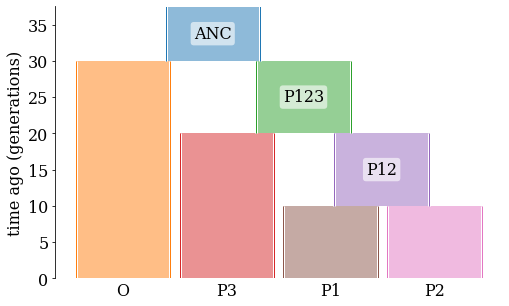

Demography(populations=[Population(initial_size=100, growth_rate=0, name='P1', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=0), Population(initial_size=100, growth_rate=0, name='P2', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=1), Population(initial_size=100, growth_rate=0, name='P3', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=2), Population(initial_size=100, growth_rate=0, name='O', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=3), Population(initial_size=100, growth_rate=0, name='P12', description='', extra_metadata={}, default_sampling_time=10, initially_active=False, id=4), Population(initial_size=100, growth_rate=0, name='P123', description='', extra_metadata={}, default_sampling_time=20, initially_active=False, id=5), Population(initial_size=100, growth_rate=0, name='ANC', description='', extra_metadata={}, default_sampling_time=30, initially_active=False, id=6)], events=[PopulationSplit(time=10, derived=['P1', 'P2'], ancestral='P12'), PopulationSplit(time=20, derived=['P12', 'P3'], ancestral='P123'), PopulationSplit(time=30, derived=['P123', 'O'], ancestral='ANC')], migration_matrix=array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]]))

In [22]:
#Example of the usage: no migration
set_demography(10,20,30,0,100)

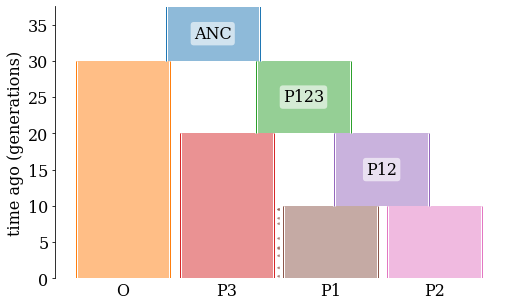

Demography(populations=[Population(initial_size=100, growth_rate=0, name='P1', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=0), Population(initial_size=100, growth_rate=0, name='P2', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=1), Population(initial_size=100, growth_rate=0, name='P3', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=2), Population(initial_size=100, growth_rate=0, name='O', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=3), Population(initial_size=100, growth_rate=0, name='P12', description='', extra_metadata={}, default_sampling_time=10, initially_active=False, id=4), Population(initial_size=100, growth_rate=0, name='P123', description='', extra_metadata={}, default_sampling_time=20, initially_active=False, id=5), Population(initial_size=100, growth_rate=0, name='ANC', description='', extra_metadata={}, default_sampling_time=30, initially_active=False, id=6)], events=[PopulationSplit(time=10, derived=['P1', 'P2'], ancestral='P12'), PopulationSplit(time=20, derived=['P12', 'P3'], ancestral='P123'), PopulationSplit(time=30, derived=['P123', 'O'], ancestral='ANC')], migration_matrix=array([[0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.1, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. ]]))

In [23]:
#Example of the usage: migration at rate 0.1
set_demography(10,20,30,0.1,100)

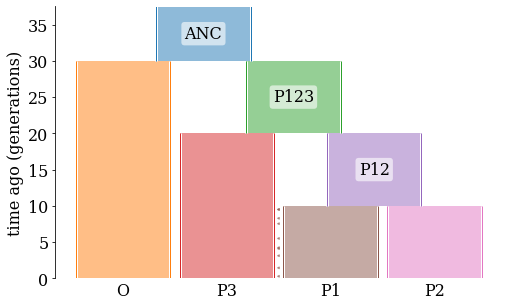

Demography(populations=[Population(initial_size=10, growth_rate=0, name='P1', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=0), Population(initial_size=10, growth_rate=0, name='P2', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=1), Population(initial_size=10, growth_rate=0, name='P3', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=2), Population(initial_size=10, growth_rate=0, name='O', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=3), Population(initial_size=10, growth_rate=0, name='P12', description='', extra_metadata={}, default_sampling_time=10, initially_active=False, id=4), Population(initial_size=10, growth_rate=0, name='P123', description='', extra_metadata={}, default_sampling_time=20, initially_active=False, id=5), Population(initial_size=10, growth_rate=0, name='ANC', description='', extra_metadata={}, default_sampling_time=30, initially_active=False, id=6)], events=[PopulationSplit(time=10, derived=['P1', 'P2'], ancestral='P12'), PopulationSplit(time=20, derived=['P12', 'P3'], ancestral='P123'), PopulationSplit(time=30, derived=['P123', 'O'], ancestral='ANC')], migration_matrix=array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]]))

In [19]:
def set_demography(t1,t2,t3,mig_rate,Ne):
    demography = msprime.Demography()
    
    #initializing populations
    demography.add_population(name="P1", initial_size=Ne)
    demography.add_population(name="P2", initial_size=Ne)
    demography.add_population(name="P3", initial_size=Ne)
    demography.add_population(name="O", initial_size=Ne)
    demography.add_population(name="P12", initial_size=Ne)
    demography.add_population(name="P123", initial_size=Ne)
    demography.add_population(name="ANC", initial_size=Ne)
    
    #adding split times
    demography.add_population_split(time=t1, derived=["P1", "P2"], ancestral="P12")
    demography.add_population_split(time=t2, derived=["P12", "P3"], ancestral="P123")
    demography.add_population_split(time=t3, derived=["P123", "O"], ancestral="ANC")
    
    #setting up gene flow
    demography.set_migration_rate("P3", "P1", mig_rate)
    
    #print(demography)
    #yield demography
    

    #Simultanious test
    ml.rcParams['figure.figsize'] = (8.0, 5.0)
    graph = msprime.Demography.to_demes(demography)
    fig, ax = plt.subplots()  # use plt.rcParams["figure.figsize"]
    demesdraw.tubes(graph, ax=ax, seed=1)
    plt.show()

    return demography

#Simultanious test
#demography = demogr(10,20,30)
#graph = msprime.Demography.to_demes(demography)
#fig, ax = plt.subplots()  # use plt.rcParams["figure.figsize"]
#demesdraw.tubes(graph, ax=ax, seed=1)
#plt.show()

set_demography(10,20,30,1,10)

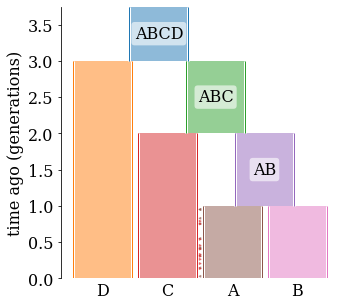

In [97]:
demography = msprime.Demography()
demography.add_population(name="A", initial_size=100)
demography.add_population(name="B", initial_size=100)
demography.add_population(name="C", initial_size=100)
demography.add_population(name="D", initial_size=100)
demography.add_population(name="AB", initial_size=100)
demography.add_population(name="ABC", initial_size=100)
demography.add_population(name="ABCD", initial_size=100)
    
demography.add_population_split(time=1, derived=["A", "B"], ancestral="AB")
demography.add_population_split(time=2, derived=["AB", "C"], ancestral="ABC")
demography.add_population_split(time=3, derived=["ABC", "D"], ancestral="ABCD")

# Set the migration rates between extant populations
demography.set_symmetric_migration_rate(["C", "A"], 9.6e-5) #asymmetric
#demography.set_symmetric_migration_rate(["B", "A"], 1.9e-5)
#demography.set_symmetric_migration_rate(["D", "A"], 3e-5)

graph = msprime.Demography.to_demes(demography)
fig, ax = plt.subplots()  # use plt.rcParams["figure.figsize"]
demesdraw.tubes(graph, ax=ax, seed=1)
plt.show()

In [ ]:
def sim_null_model_flex(num_replicates,t12,t23,t34):
    demography = msprime.Demography()
    demography.add_population(name="A", initial_size=100)
    demography.add_population(name="B", initial_size=100)
    demography.add_population(name="C", initial_size=100)
    demography.add_population(name="D", initial_size=100)
    demography.add_population(name="AB", initial_size=100)
    demography.add_population(name="ABC", initial_size=100)
    demography.add_population(name="ABCD", initial_size=100)
    demography.add_population_split(time=t12, derived=["A", "B"], ancestral="AB")
    demography.add_population_split(time=t23, derived=["AB", "C"], ancestral="ABC")
    demography.add_population_split(time=t34, derived=["ABC", "D"], ancestral="ABCD")
    #ancestry_reps = msprime.sim_ancestry(samples={"A": 1, "B": 1, "C": 1, "D": 1}, sequence_length=10000, demography=demography, num_replicates=num_replicates)
    ancestry_reps = msprime.sim_ancestry(samples={"A": 1, "B": 1, "C": 1, "D": 1}, 
                                         demography=demography, sequence_length=10000,
                                         num_replicates=num_replicates, ploidy=1)
    for ts in ancestry_reps:
        mutated_ts = msprime.sim_mutations(ts, rate=(1/10000))
        yield ts